Import Modules

In [1]:
#Stacked LSTM

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance
import haha


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)
log_dir = "../../assets/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Pre modelling

Load dataset

In [34]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

Rescale data

In [35]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values.reshape(-1,1))
df=scaler.transform(df.values.reshape(-1,1))

Train Test split

In [36]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

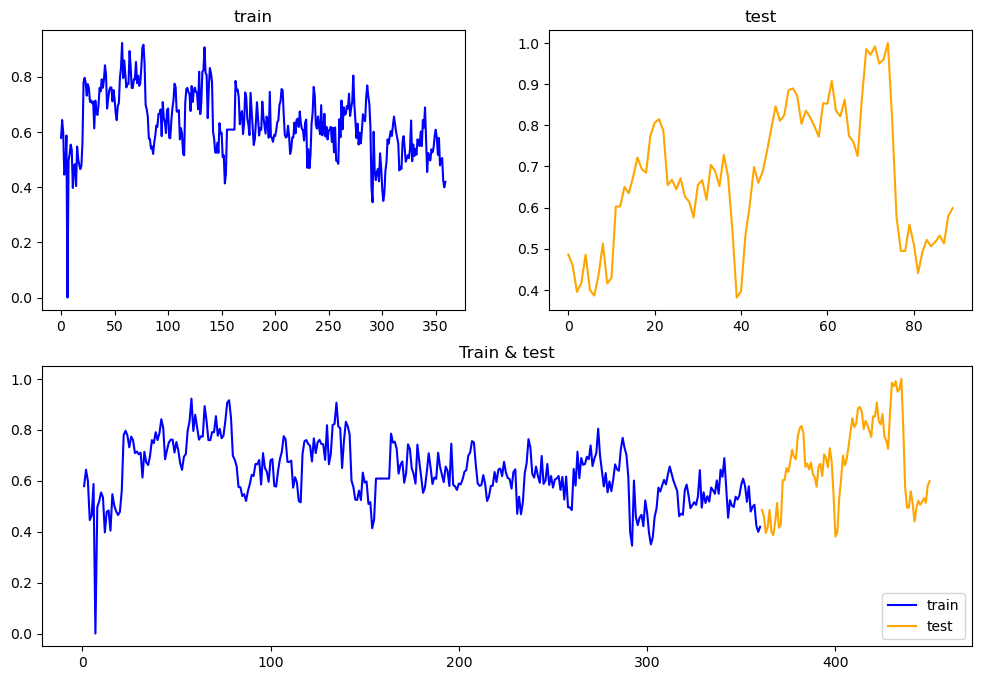

In [37]:
haha.plottraintest(train, test)

lag variable

In [38]:
# reshape into X=t and Y=t+1
t=30
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [39]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, features, time steps]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Modelling and fitting

declare necessities 

In [23]:
def r2scoremetrics(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - (SS_res/SS_tot) )                              #Doesn't get used due to a misleading val_score during training

def thecallback():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]

Model

In [41]:
batch_size=32

#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, input_shape=(t, 1), return_sequences=True),                   #input and 1st memory block
        keras.layers.LSTM(8),                                          #2nd memory block
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
    return model

Fitting

In [42]:
model=getmodel_compile()

thehistory=model.fit(trainX, trainY, epochs=1000, validation_data=(testX, testY), batch_size=batch_size, verbose=1, callbacks=thecallback())

Epoch 1/1000
11/11 [==============================] - 4s 112ms/step - loss: 0.1739 - mean_absolute_error: 0.4006 - mean_absolute_percentage_error: 61.8834 - val_loss: 0.1529 - val_mean_absolute_error: 0.3552 - val_mean_absolute_percentage_error: 46.5166
Epoch 2/1000
11/11 [==============================] - 0s 25ms/step - loss: 0.0492 - mean_absolute_error: 0.1935 - mean_absolute_percentage_error: 28.8646 - val_loss: 0.0414 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 23.2703
Epoch 3/1000
11/11 [==============================] - 0s 24ms/step - loss: 0.0118 - mean_absolute_error: 0.0864 - mean_absolute_percentage_error: 14.6246 - val_loss: 0.0264 - val_mean_absolute_error: 0.1371 - val_mean_absolute_percentage_error: 22.0557
Epoch 4/1000
11/11 [==============================] - 0s 25ms/step - loss: 0.0142 - mean_absolute_error: 0.0971 - mean_absolute_percentage_error: 17.2540 - val_loss: 0.0282 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_er

In [43]:
model.save("../../assets/testt30.keras")

Check fitting metrics history

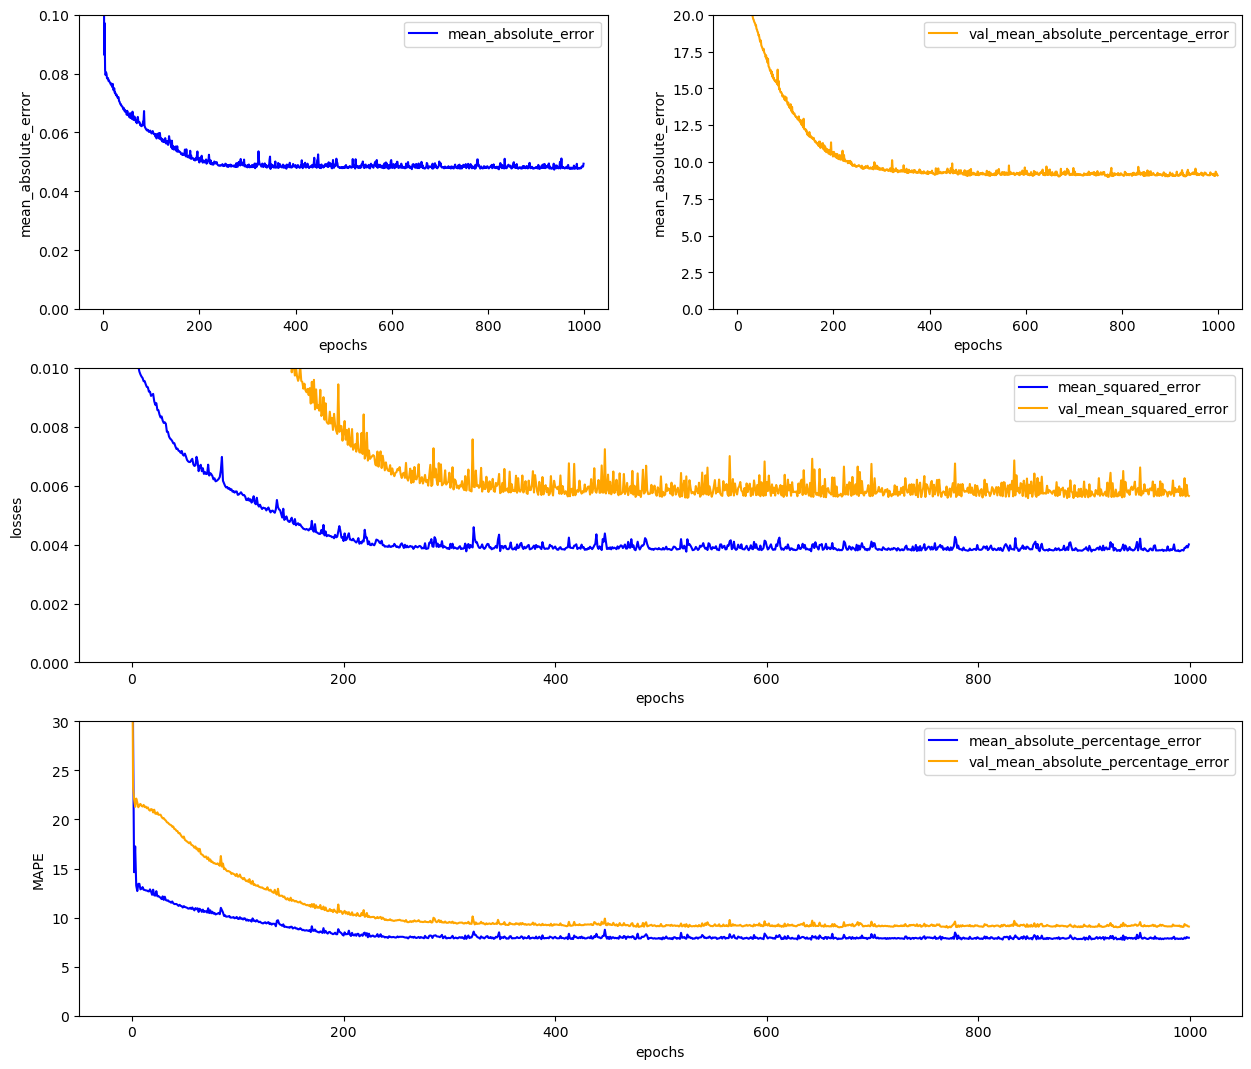

In [57]:
#Metrics result won't be that accurate due to to normalizing -Rei 
def theplot(history):
    fig = plt.figure(figsize=(15,13))
    ax=fig.add_subplot(3,2,1)
    ax.plot(history.history["mean_absolute_error"], label="mean_absolute_error", c="blue")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.1)
    
    ax=fig.add_subplot(3,2,2)
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,20)
    
    ax=fig.add_subplot(3,1,2)
    ax.plot(history.history["loss"], label="mean_squared_error", c="blue")
    ax.plot(history.history["val_loss"], label="val_mean_squared_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.01)
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")
    
    ax=fig.add_subplot(3,1,3)
    ax.plot(history.history["mean_absolute_percentage_error"], label="mean_absolute_percentage_error", c="blue")
    ax.legend(loc="lower right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.set_ylim(0,30)

theplot(thehistory)

In [122]:
model=keras.models.load_model("../../assets/testt15.keras",  custom_objects={"r2scoremetrics": r2scoremetrics})

Get predicted train and test

In [58]:
#predict
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

2/2 [==============================] - 0s 6ms/step


In [59]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
testPredict = scaler.inverse_transform(testPredict).flatten()


testY = scaler.inverse_transform([testY]).flatten()
trainY = scaler.inverse_transform([trainY]).flatten()

Metrics of the predicted by the model

In [65]:
# Evaluation metrics
import math
print("Train")
print(f'RMSE    :   {math.sqrt(mean_squared_error(trainY,trainPredict))}')
print(f'MSE     :   {mean_squared_error(trainY,trainPredict)}')
print(f'MAE     :   {mean_absolute_error(trainY,trainPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(trainY,trainPredict)}')
print(f'R2score :   {r2_score(trainY, trainPredict)}')


print("\nTest")
print(f'RMSE    :   {math.sqrt(mean_squared_error(testY,testPredict))}')
print(f'MSE     :   {mean_squared_error(testY,testPredict)}')
print(f'MAE     :   {mean_absolute_error(testY,testPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(testY,testPredict)}')
print(f'R2score :   {r2_score(testY, testPredict)}')

Train
RMSE    :   4.902948270909642
MSE     :   24.03890174721585
MAE     :   3.796128231462133
MAPE    :   0.02007773233513228
R2score :   0.6660117269574513

Test
RMSE    :   5.968768387367263
MSE     :   35.62619606203479
MAE     :   4.695896270809421
MAPE    :   0.02413870118102982
R2score :   0.7884939884034344


Predicted vs actual plot

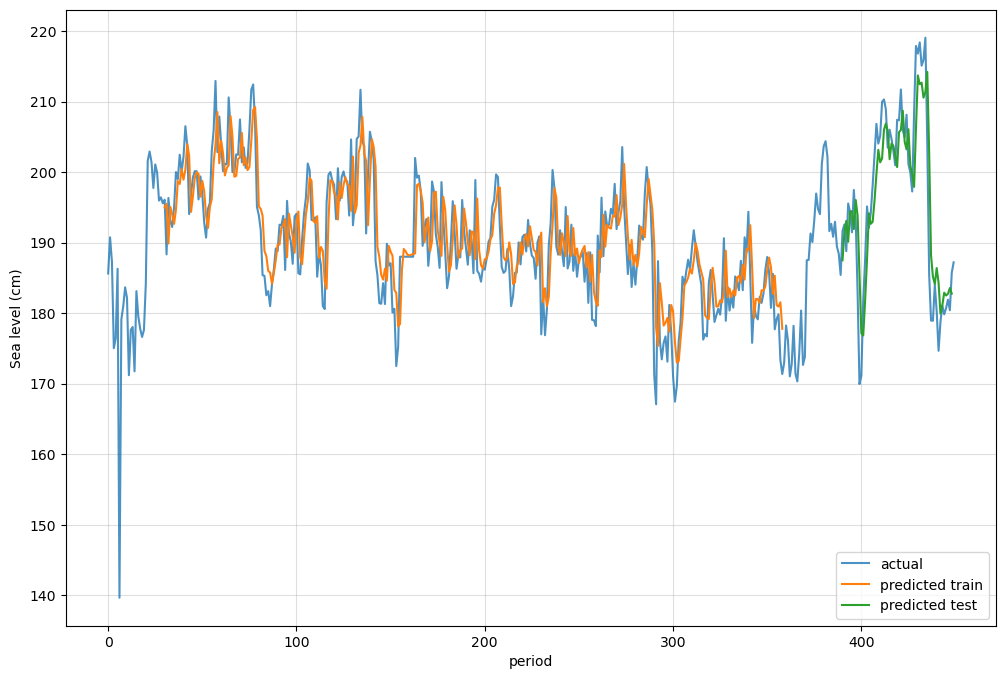

In [67]:
haha.plot_predicted(scaler.inverse_transform(df), trainPredict.reshape(-1,1), testPredict.reshape(-1,1), t)

## Forecasting

Get the next 60 days

In [68]:
def forecast(predictedday, model, testdata, t):
    forecasted=[]
    theinput=testdata[-t:]

    firstinput = theinput.reshape((1, t,1))
    temppredicted = model.predict(firstinput, verbose=0)
    theinput=np.concatenate((theinput, temppredicted), axis=0)
    forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1)))
    
    for i in range(1,predictedday):
        theinput=theinput[1:].flatten().reshape(1,t,1)
        temppredicted=model.predict(theinput, verbose=0)
        theinput=np.concatenate((theinput.reshape(-1,1), temppredicted), axis=0)
        forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1)))
        
    return forecasted


z=forecast(predictedday=60, model=model, testdata=test, t=t)

In [69]:
z

[array([[187.8389]], dtype=float32),
 array([[188.37405]], dtype=float32),
 array([[188.66867]], dtype=float32),
 array([[188.8922]], dtype=float32),
 array([[189.12384]], dtype=float32),
 array([[189.37256]], dtype=float32),
 array([[189.63196]], dtype=float32),
 array([[189.90495]], dtype=float32),
 array([[190.1689]], dtype=float32),
 array([[190.4179]], dtype=float32),
 array([[190.61934]], dtype=float32),
 array([[190.80978]], dtype=float32),
 array([[190.97285]], dtype=float32),
 array([[191.10628]], dtype=float32),
 array([[191.21123]], dtype=float32),
 array([[191.31798]], dtype=float32),
 array([[191.44313]], dtype=float32),
 array([[191.58134]], dtype=float32),
 array([[191.72363]], dtype=float32),
 array([[191.89714]], dtype=float32),
 array([[192.08344]], dtype=float32),
 array([[192.24911]], dtype=float32),
 array([[192.43784]], dtype=float32),
 array([[192.62862]], dtype=float32),
 array([[192.81061]], dtype=float32),
 array([[192.97472]], dtype=float32),
 array([[193.129

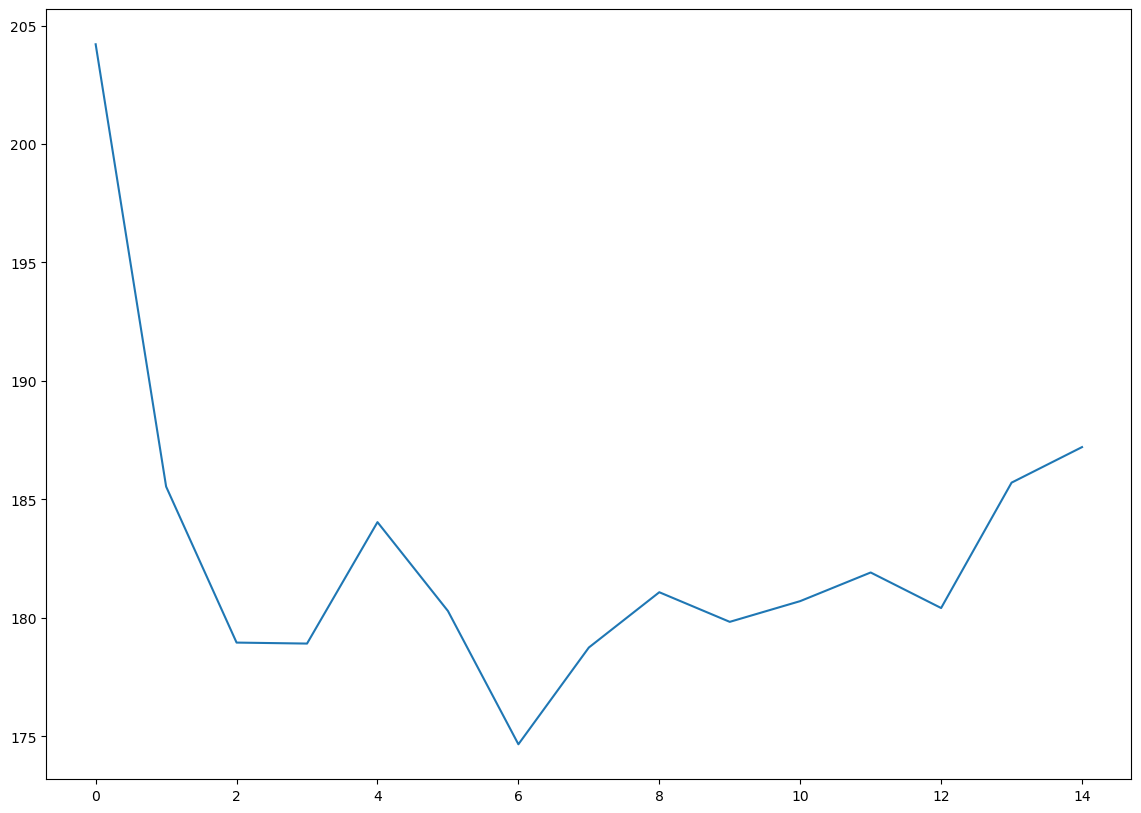

In [138]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
ax.plot(scaler.inverse_transform(test[-t:]))

In [40]:
last_days=np.arange(1,t+1)
day_pred=np.arange(t+1,t+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [41]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

In [167]:
last_original_days_value[0:t+1] = df[len(df)-t:].reshape(1,-1).tolist()[0]
next_predicted_days_value[t+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days','Predicted next 30 days'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Sea level','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Sea level')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [176]:
lstmdf=df.tolist()
lstmdf.extend((scaler.inverse_transform(lst_output).reshape(-1,1)).tolist())
lstmdf=np.array(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Sea level'])

fig = px.line(lstmdf,labels={'value': 'Sea level','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole data with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Label')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()